In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from subprocess import check_output
from wordcloud import WordCloud
import itertools
from pandas.api.types import is_numeric_dtype

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import f1_score

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_yout = pd.read_csv("merged_files.csv")

# **Type of each columns**

In [ ]:
df_yout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7900 entries, 0 to 7899
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         7900 non-null   int64 
 1   video_id           7900 non-null   object
 2   title              7900 non-null   object
 3   publishedAt        7900 non-null   object
 4   channelId          7900 non-null   object
 5   channelTitle       7900 non-null   object
 6   categoryId         7900 non-null   int64 
 7   trending_date      7900 non-null   object
 8   view_count         7900 non-null   int64 
 9   likes              7900 non-null   int64 
 10  comment_count      7900 non-null   int64 
 11  comments_disabled  7900 non-null   bool  
 12  description        7832 non-null   object
 13  age                7900 non-null   int64 
 14  rating_disabled    7900 non-null   bool  
dtypes: bool(2), int64(6), object(7)
memory usage: 817.9+ KB


Number of columns and rows of this dataset

In [ ]:
print(df_yout.shape)

(7900, 15)


Number of unique values of each feature

In [ ]:
print(df_yout.nunique())

Unnamed: 0           7900
video_id             5121
title                5141
publishedAt          5039
channelId            2817
channelTitle         2818
categoryId             15
trending_date          40
view_count           7011
likes                6691
comment_count        3637
comments_disabled       2
description          4938
age                   374
rating_disabled         2
dtype: int64


Number of duplicated rows

In [ ]:
num_dups = (df_yout.pivot_table(index = ['video_id'], aggfunc='size') - 1).sum()
num_dups

2779

Drop duplicates

In [ ]:
df_yout.drop_duplicates(subset='video_id', keep="first", inplace = True)

**Number** of missing values of each feature



In [ ]:
# Replace NaN in description with space
print(df_yout['description'].isnull().sum())
df_yout['description'].fillna(" ", inplace=True)

49


In [ ]:
df_yout['title'].isnull().sum()

0

Correct negative values, if any

In [ ]:
test = df_yout['likes']
print(test[test<0].count())

0


In [ ]:
test = df_yout['comment_count']
print(test[test<0].count())

0


In [ ]:
test = df_yout['view_count']
print(test[test<0].count())

0


# Let's start looking if Views, likes, and comment counts have a Gaussian Distribution


In [ ]:
df_yout['likes_log'] = np.log(df_yout['likes'] + 1)
df_yout['views_log'] = np.log(df_yout['view_count'] + 1)
df_yout['comment_log'] = np.log(df_yout['comment_count'] + 1)

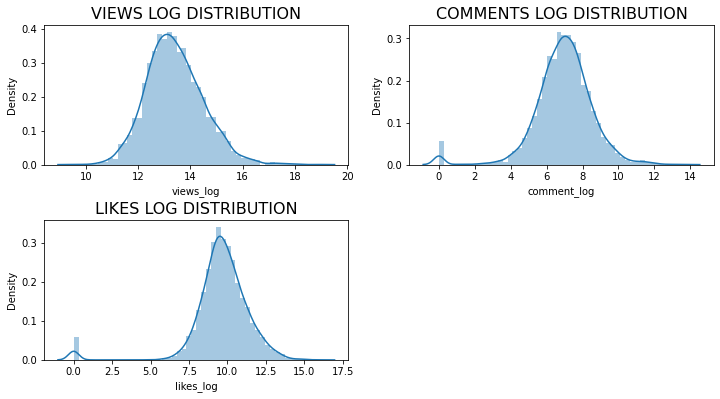

In [ ]:
plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(df_yout['views_log'])
g1.set_title("VIEWS LOG DISTRIBUTION", fontsize=16)

plt.subplot(223)
g2 = sns.distplot(df_yout['likes_log'])
g2.set_title('LIKES LOG DISTRIBUTION', fontsize=16)

plt.subplot(222)
g4 = sns.distplot(df_yout['comment_log'])
g4.set_title("COMMENTS LOG DISTRIBUTION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)
plt.show()


#Looking the Views, likes, distribution by category_name's 

In [ ]:
df_yout['category_name'] = np.nan

df_yout.loc[(df_yout["categoryId"] == 1),"category_name"] = 'Film & Animation'
df_yout.loc[(df_yout["categoryId"] == 2),"category_name"] = 'Autos & Vehicles'
df_yout.loc[(df_yout["categoryId"] == 10),"category_name"] = 'Music'
df_yout.loc[(df_yout["categoryId"] == 15),"category_name"] = 'Pets & Animals'
df_yout.loc[(df_yout["categoryId"] == 17),"category_name"] = 'Sports'
df_yout.loc[(df_yout["categoryId"] == 18),"category_name"] = 'Short Movies'
df_yout.loc[(df_yout["categoryId"] == 19),"category_name"] = 'Travel and Events'
df_yout.loc[(df_yout["categoryId"] == 20),"category_name"] = 'Gaming'
df_yout.loc[(df_yout["categoryId"] == 21),"category_name"] = 'Videoblogging'
df_yout.loc[(df_yout["categoryId"] == 22),"category_name"] = 'People and Blogs'
df_yout.loc[(df_yout["categoryId"] == 23),"category_name"] = 'Comedy'
df_yout.loc[(df_yout["categoryId"] == 24),"category_name"] = 'Entertainment'
df_yout.loc[(df_yout["categoryId"] == 25),"category_name"] = 'News & Politics'
df_yout.loc[(df_yout["categoryId"] == 26),"category_name"] = 'Howto & Style'
df_yout.loc[(df_yout["categoryId"] == 27),"category_name"] = 'Education'
df_yout.loc[(df_yout["categoryId"] == 28),"category_name"] = 'Science & Technology'
df_yout.loc[(df_yout["categoryId"] == 30),"category_name"] = 'Movies'
df_yout.loc[(df_yout["categoryId"] == 31),"category_name"] = 'Anime/Animation'
df_yout.loc[(df_yout["categoryId"] == 32),"category_name"] = 'Action/Adventure'
df_yout.loc[(df_yout["categoryId"] == 33),"category_name"] = 'Classics'
df_yout.loc[(df_yout["categoryId"] == 34),"category_name"] = 'Comedy'
df_yout.loc[(df_yout["categoryId"] == 35),"category_name"] = 'Documentary'
df_yout.loc[(df_yout["categoryId"] == 36),"category_name"] = 'Drama'
df_yout.loc[(df_yout["categoryId"] == 37),"category_name"] = 'Family'
df_yout.loc[(df_yout["categoryId"] == 38),"category_name"] = 'Foreign'
df_yout.loc[(df_yout["categoryId"] == 39),"category_name"] = 'Horror'
df_yout.loc[(df_yout["categoryId"] == 40),"category_name"] = 'Sci-Fi/Fantasy'
df_yout.loc[(df_yout["categoryId"] == 41),"category_name"] = 'Thriller'
df_yout.loc[(df_yout["categoryId"] == 42),"category_name"] = 'Shorts'
df_yout.loc[(df_yout["categoryId"] == 43),"category_name"] = 'Shows'
df_yout.loc[(df_yout["categoryId"] == 44),"category_name"] = 'Trailers'


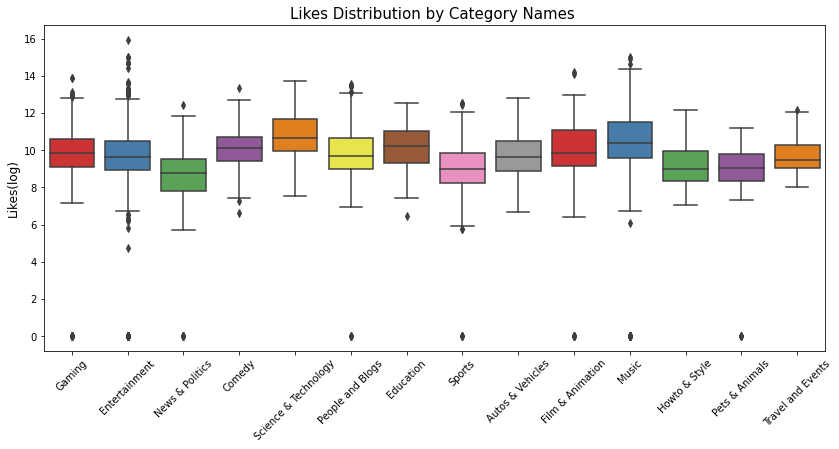

In [ ]:
plt.figure(figsize = (14,6))

g = sns.boxplot(x='category_name', y='likes_log', data=df_yout, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Likes Distribution by Category Names ", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Likes(log)", fontsize=12)
plt.show()

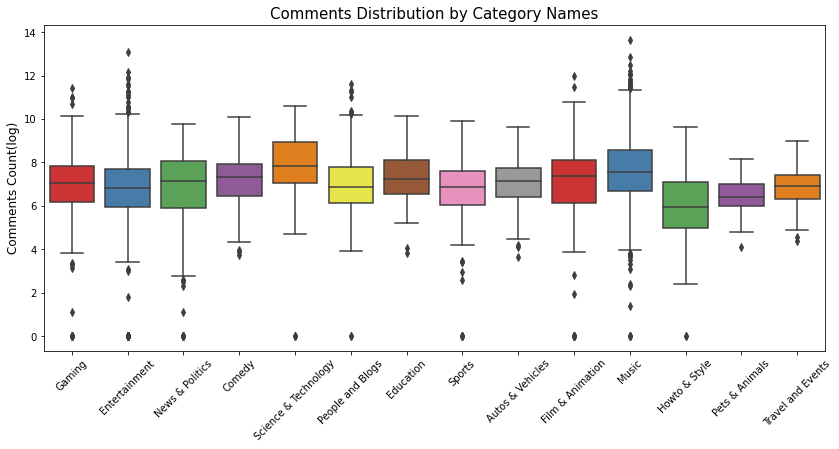

In [ ]:
plt.figure(figsize = (14,6))

g = sns.boxplot(x='category_name', y='comment_log', data=df_yout, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Comments Distribution by Category Names", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Comments Count(log)", fontsize=12)

plt.show()

# Analysing the Correlation Matrix of the numerical variables

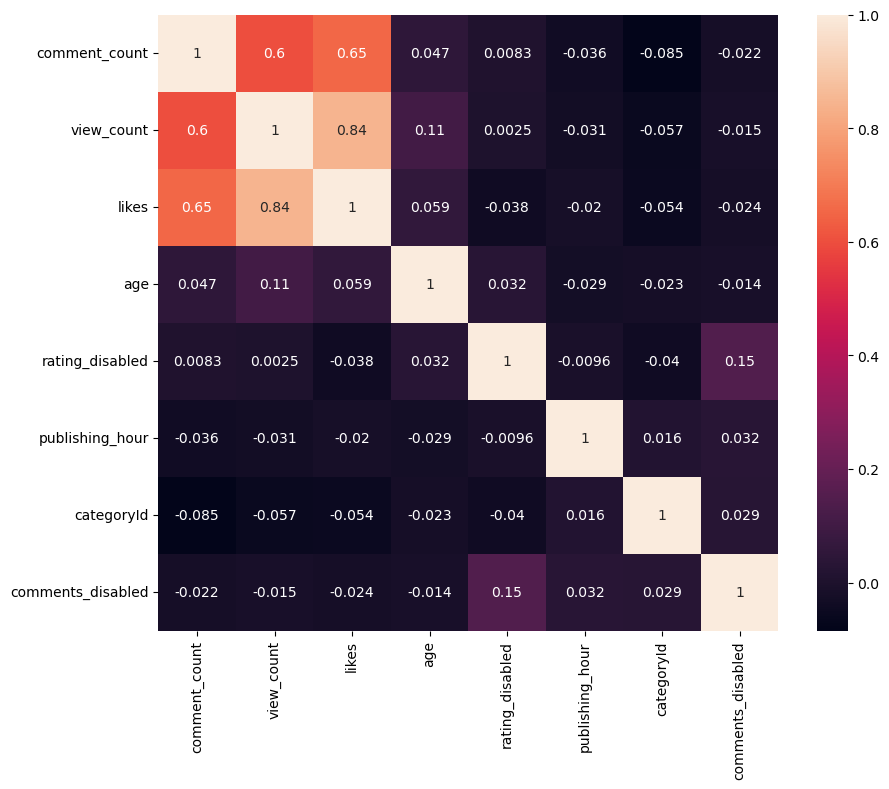

In [ ]:
plt.figure(figsize = (10,8))

#Let's verify the correlation of each value
sns.heatmap(df_yout[['comment_count', 'view_count', 'likes', 'age', 'rating_disabled', 'publishing_hour', 'categoryId', 'comments_disabled']].corr(), annot=True)
plt.show()

# Does the puplishing hour affect the trending capability?

In [ ]:
hour = df_yout['publishedAt'].apply(lambda date: (date.split("T")[1].split(":"))[0])
df_yout['publishing_hour'] = hour
df_yout['publishing_hour'] = df_yout['publishing_hour'].astype(int)
print(df_yout['publishing_hour'].value_counts()[:5])

9     513
10    411
11    378
12    271
15    269
Name: publishing_hour, dtype: int64


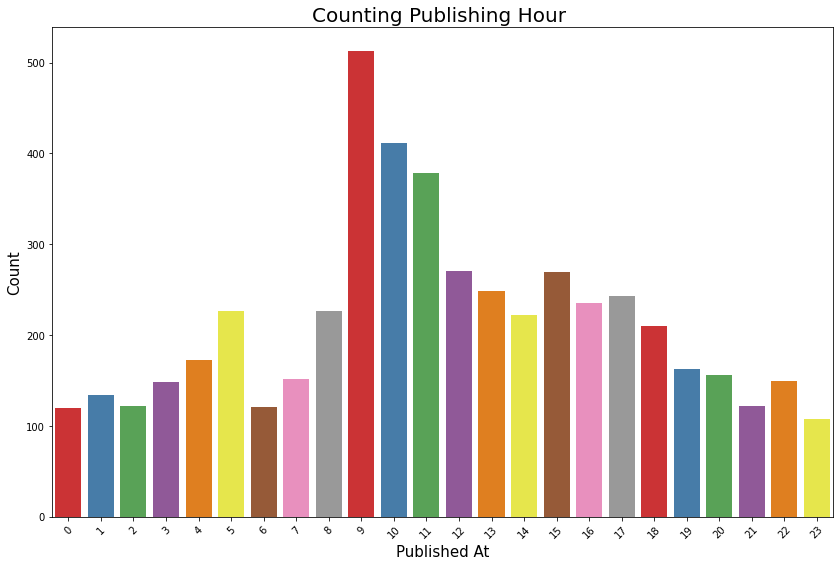

In [ ]:
plt.figure(figsize = (14,9))

g = sns.countplot('publishing_hour', data=df_yout, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Publishing Hour ", fontsize=20)
g.set_xlabel("Published At", fontsize=15)
g.set_ylabel("Count", fontsize=15)

plt.show()

# Do specific words in title affect the trending ability?

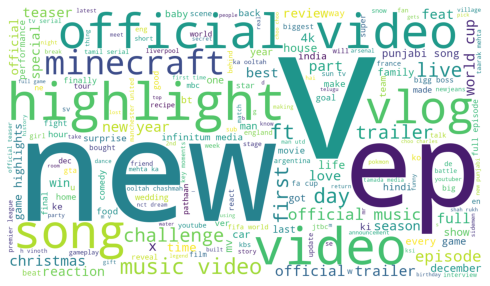

In [ ]:
# create empty string to hold all video titles later
text = ''
printable = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n'

# filter all the titles to leave only printable characters
df_yout['title'] = df_yout['title'].apply(
    lambda x: ''.join(filter(lambda xi: xi in printable, x)))
# get each video title, break the words into tokens and add to 'text'
for x in df_yout.index:
    title = str(df_yout.loc[x, 'title'])

    tokens = title.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    text += ' '.join(tokens)+' '

# generate word cloud
cloud = WordCloud(
    width=1400, height=800, background_color='white', min_font_size=12).generate(text)
# plot the word cloud
plt.figure(figsize=(8, 14), facecolor=None)
plt.imshow(cloud)
plt.axis("off")
plt.tight_layout(pad=5)
plt.show()

# Does the title length affect the Youtube trending tab?

In [ ]:
df_yout['title'].isnull().sum()

0

In [ ]:
df_yout['title_len'] = df_yout['title'].str.len()
df_yout.loc[df_yout['title_len'] == 1]

,Unnamed: 0,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,view_count,likes,...,comments_disabled,description,age,rating_disabled,likes_log,views_log,comment_log,publishing_hour,category_name,title_len
441,441,MB8Z2V-ngL0,,2022-12-10T10:00:17Z,UCtBnofpvdI3Fbn6f7QclmYQ,あめんぼぷらす【日常コメディ】,17,13-12-2022T23:08:28Z,861766,20750,...,False,〜あめぷら漫画単行本発売決定〜\nhttps://www.amazon.co.jp/dp/4...,85,False,9.940350,13.666740,7.289611,10,Sports,1
450,450,fKXZN8enoL4,,2022-12-10T09:00:18Z,UCCp9Q2JCLjOenDa63FJi_Ag,陣内智則のネタジン,24,13-12-2022T23:08:28Z,491391,7898,...,False,今回は新ネタ「コント ガラケー復旧」\n昔のガラケーを復旧して中のデータを見られるようにする...,86,False,8.974491,13.104997,6.204558,9,Entertainment,1
453,453,iOFvpp2OJ4c,C,2022-12-10T08:00:30Z,UCXw-7zNPhqafIR0o-vqXX3w,SATAbuilder's,26,13-12-2022T23:08:28Z,485492,10373,...,False,入念なリサーチでカメラマン宇野が、\nスプロケとチェーンを金にしたい事を知った総長!!\n知...,87,False,9.247058,13.092920,6.802395,8,Howto & Style,1
502,502,qOJAC_CogVY,/,2022-12-09T09:00:28Z,UCIZzHNbzlIskx3TxGznRyYg,主役は我々だ!,20,13-12-2022T23:08:28Z,304559,15274,...,False,●天界･感想編はこちら！→https://www.nicovideo.jp/watch/16...,110,False,9.633973,12.626623,6.184149,9,Gaming,1
513,513,FyYpyHpH9vE,#,2022-12-07T15:52:04Z,UCvzGlP9oQwU--Y0r9id_jnA,Subaru Ch. 大空スバル,20,13-12-2022T23:08:28Z,538542,18003,...,False,@HoushouMarine \n\n🐣4周年記念グッズはこちらから🐣\nhttps://s...,151,False,9.798349,13.196623,5.905362,15,Gaming,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5449,5449,xbCj8Z-prXs,,2023-01-22T10:33:36Z,UCNsidkYpIAQ4QaufptQBPHQ,ウェザーニュース,25,26-01-2023T22:01:35Z,342876,1101,...,False,24日(火)から25日(水)にかけて、日本列島の上空に近年で最も強いレベルの寒気が南下します...,107,False,7.004882,12.745127,4.430817,10,News & Politics,1
5939,5939,gd6B4kRgI78,,2023-01-27T05:03:02Z,UCdeb5b3bAxn1OXXFFeuCaHg,TOMORROW X TOGETHER - Topic,10,27-01-2023T23:48:14Z,351521,69414,...,False,Provided to YouTube by 'BIGHIT MUSIC'\n\n네버랜드를...,18,False,11.147858,12.770028,8.116417,5,Music,1
6331,6331,F8sXHB6scpU,#,2023-01-26T13:00:09Z,UCwi4P78SVunSYAGrvC9aKcw,ROF-MAO / ろふまおチャンネル【にじさんじ】,24,27-01-2023T23:48:22Z,360516,0,...,False,カッコいい大人なら畝立てもできるはず！\n\nろふまお農業第4回！\n畑がまたもや雑草まみれ...,34,True,0.000000,12.795294,6.300786,13,Entertainment,1
6337,6337,mGfhLK202fk,/,2023-01-26T09:00:32Z,UCIZzHNbzlIskx3TxGznRyYg,主役は我々だ!,20,27-01-2023T23:48:22Z,325818,22611,...,False,ロボロは反則\n\n誰でも見られる！裏話･感想はこちら！→https://www.nicov...,38,False,10.026236,12.694097,6.776507,9,Gaming,1


Drop the title length = 0 for the copy version since pandas cannot detect other languages apart from englis

In [ ]:
df_yout_filtered = df_yout[df_yout['title_len'] > 0]
df_yout_filtered.loc[df_yout['title_len'] == 3]

,Unnamed: 0,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,view_count,likes,...,comments_disabled,description,age,rating_disabled,likes_log,views_log,comment_log,publishing_hour,category_name,title_len
400,400,VCtrHxvVOFQ,30,2022-12-12T10:00:11Z,UCz6vnIbgiqFT9xUcD6Bp65Q,ChroNoiR,24,13-12-2022T23:08:28Z,367504,21553,...,False,100000人（叶） \nクレタクションありがとう😭（葛葉）\n\nくろなん凸待ち企画！\n...,37,False,9.978317,12.814492,6.049733,10,Entertainment,3
408,408,ZiyAqlJuZz8,www,2022-12-12T09:30:05Z,UCI0xPNkgivK-FCcaCYDC8Yg,ヘラヘラ三銃士,24,13-12-2022T23:08:28Z,673426,10557,...,False,@Banbanzai \n\nばんばんざいチャンネルの動画はこちらから！\nhttps://...,37,False,9.264639,13.420135,5.693732,9,Entertainment,3
424,424,Sh8rZRJ2xzE,www,2022-12-12T11:00:25Z,UCP-32CzsbLiiIb2LbYk8mZA,Lazy Lie Crazy【レイクレ】,23,13-12-2022T23:08:28Z,375163,10315,...,False,＃レイクレ＃面白かったらいいね＃チャンネル登録よろしく\n\n次の相手のチャンネル\nhtt...,36,False,9.241451,12.835119,6.792344,11,Comedy,3
434,434,BITVom8WFBM,/,2022-12-11T09:18:50Z,UClNdVSK1uy2xFHTaXZYXopw,らっだぁ,20,13-12-2022T23:08:28Z,439175,21658,...,False,◆ほぼ毎日ここで生配信してます\n→https://www.twitch.tv/radera...,61,False,9.983176,12.992656,6.601230,9,Gaming,3
435,435,HWrqSzp1PFE,#49,2022-12-11T11:00:09Z,UCUApURCve0BEqv6Sa9x_OJg,my channel【白石麻衣 公式】,24,13-12-2022T23:08:28Z,337982,15149,...,False,ご視聴いただき、ありがとうございます！\n\n今回は乃木坂配信中とのコラボ動画になります。\...,60,False,9.625756,12.730751,6.705639,11,Entertainment,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,5422,KzCFho7OUnM,500,2023-01-21T10:30:06Z,UCFo4kqllbcQ4nV83WCyraiw,中田敦彦のYouTube大学 - NAKATA UNIVERSITY,24,26-01-2023T22:01:35Z,830140,17604,...,False,この動画の前編・後編はこちら\n前編：https://youtu.be/KzCFho7OUn...,131,False,9.775938,13.629351,6.885510,10,Entertainment,3
5432,5432,OyOu0B0GcTQ,vs2,2023-01-22T09:58:02Z,UCI4mta4pWhYhPSLhjmUAfZQ,毎日新聞,25,26-01-2023T22:01:35Z,234908,0,...,False,第72期王将戦第2局の終局後に行われるインタビューと感想戦をライブ配信でお届けします。\n\...,108,True,0.000000,12.366953,4.189655,9,News & Politics,3
5436,5436,msVI02tnV0k,...,2023-01-21T11:00:07Z,UC8_wmm5DX9mb4jrLiw8ZYzw,スカイピース,24,26-01-2023T22:01:35Z,1845049,36217,...,False,@mizutamaribond \n@SAWAYANCHANNEL \n@HeiseiFla...,131,False,10.497312,14.428017,7.382124,11,Entertainment,3
6335,6335,XjryWF7P70U,127,2023-01-26T09:30:06Z,UCxlsYyeri8MOpap3w3JbWSQ,まあたそ,24,27-01-2023T23:48:22Z,517108,16610,...,False,この日なんだか疲れてたのでホントのリアルです💭\nせっかくじゃからやったけど普段YouTub...,38,False,9.717820,13.156009,6.647688,9,Entertainment,3


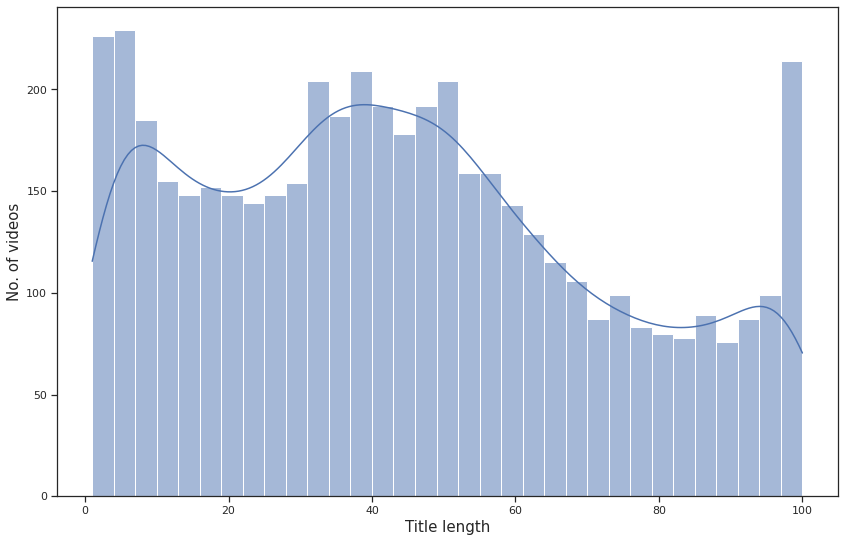

In [ ]:
plt.figure(figsize = (14,9))
sns.set(style = 'ticks')
h = sns.histplot(x = "title_len", data = df_yout_filtered, binwidth = 3, kde = True)
h.set_xlabel("Title length", fontsize=15)
h.set_ylabel("No. of videos", fontsize=15)

plt.show()

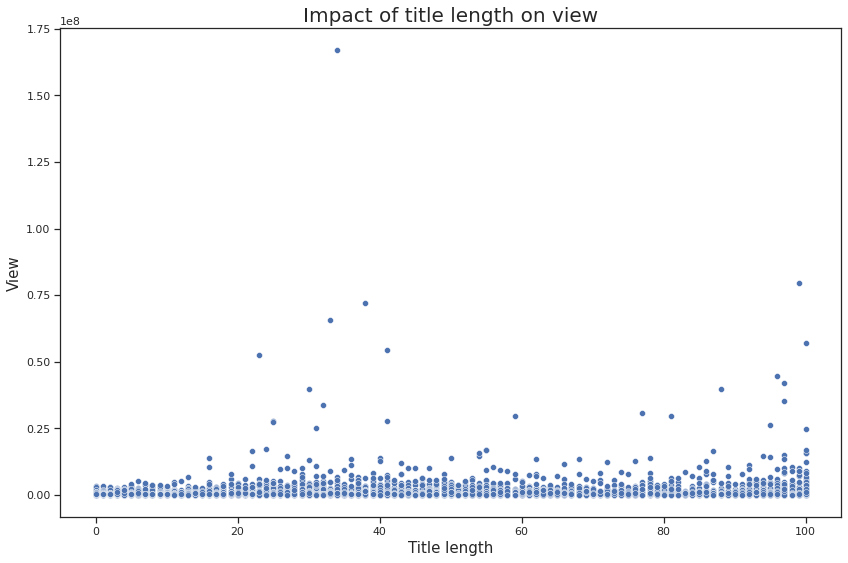

In [ ]:
plt.figure(figsize = (14,9))
sns.set(style = 'ticks')
h = sns.scatterplot(x = "title_len", y = "view_count", data = df_yout)
h.set_title("Impact of title length on view", fontsize=20)
h.set_xlabel("Title length", fontsize=15)
h.set_ylabel("View", fontsize=15)

plt.show()

# Does the holiday season affect the Youtube trending tab?

In [ ]:
keywords = ['christmas', 'xmas', 'holiday', 'santa', 'snow', 'noel', 'present', 'gift', 'new year',
		'クリスマス', 'ホリデー', 'ノエル','サンタ', '雪', '贈り物', '新年',
		'kurisumasu', 'horidē', 'horidee', 'yuki', 'noeru', 'okurimono', "shin'nen",
		'크리스마스', '휴일', '산타', '눈', '현재', '선물', '새해',
		'keuliseumaseu', 'hyuil', 'nun', 'hyeonjae', 'seonmul', 'saehae',
		'क्रिसमस', 'छुट्टी का दिन', 'सांता', 'बर्फ', 'नोएल', 'वर्तमान', 'उपहार', 'नया साल'
		'krisamas', 'chhuttee ka din', 'saanta', 'barph', 'vartamaan', 'upahaar', 'naya saal']

In [100]:
DATES = ['03-01-2023T21:46:20Z', '20-12-2022T23:18:22Z']
df_before_holiday = df_yout[df_yout['trending_date'] == DATES[1]]
df_during_holiday = df_yout[df_yout['trending_date'] == DATES[0]]

In [101]:
# count holiday-related videos
## before holiday
count_before = 0
for _, row in df_before_holiday.iterrows():
  if any(keyword in row['title'].lower() for keyword in keywords) or any(keyword in row['description'].lower() for keyword in keywords):
    count_before += 1
## after holiday
count_during = 0
for _, row in df_during_holiday.iterrows():
  if any(keyword in row['title'].lower() for keyword in keywords) or any(keyword in row['description'].lower() for keyword in keywords):
    count_during += 1

In [102]:
# prepare data for plot
total = [len(df_before_holiday), len(df_during_holiday)]
related = [count_before, count_during]
non_related = [total[0] - related[0], total[1] - related[1]]
labels = ['before holiday (total = {0} videos)'.format(total[0]),
  'after holiday (total = {0} videos)'.format(total[1])]

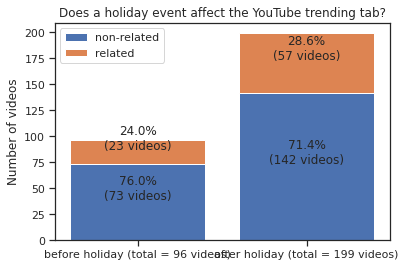

In [103]:
# plot data
_, ax = plt.subplots()
## create stacked bars
ax.bar(labels, non_related, label='non-related')
ax.bar(labels, related, bottom=non_related, label='related')
## show percentage of non-relted videos
for i in range(len(ax.patches)):
  rec = ax.patches[i]
  if i < 2:
    ax.text(ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_y() + ax.patches[i].get_height() / 2,
      "{pct:.1f}%\n({num} videos)".format(pct=(non_related[i] / total[i]) * 100, num=non_related[i]),
      ha='center', va='bottom')
  else:
    ax.text(ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_y() + ax.patches[i].get_height() / 2,
      "{pct:.1f}%\n({num} videos)".format(pct=(related[i - 2] / total[i - 2]) * 100, num=related[i - 2]),
      ha='center', va='bottom')
## set metadata
ax.set_ylabel('Number of videos')
ax.set_title('Does a holiday event affect the YouTube trending tab?')
ax.legend()
## show plot
plt.show()


# What is the average view for each category to trend? 

In [ ]:
CATEGORIES = {1: 'Film & Animation',\
	2: 'Autos & Vehicles',\
	10: 'Music',\
	15: 'Pets & Animals',\
	17: 'Sports',\
	18: 'Short Movies',\
	19: 'Travel & Events',\
	20: 'Gaming',\
	21: 'Videoblogging',\
	22: 'People & Blogs',\
	23: 'Comedy',\
	24: 'Entertainment',\
	25: 'News & Politics',\
	26: 'Howto & Style',\
	27: 'Education',\
	28: 'Science & Technology',\
	29: 'Nonprofits & Activism',\
	30: 'Movies',\
	31: 'Anime/Animation',\
	32: 'Action/Adventure',\
	33: 'Classics',\
	34: 'Comedy',\
	35: 'Documentary',\
	36: 'Drama',\
	37: 'Family',\
	38: 'Foreign',\
	39: 'Horror',\
	40: 'Sci-Fi/Fantasy',\
	41: 'Thriller',\
	42: 'Shorts',\
	43: 'Shows',\
	44: 'Trailers'}

In [ ]:
# fill frequency table of categories
frequency = {}
for _, row in df_yout.iterrows():
    try:
        frequency[CATEGORIES[row['categoryId']]]['videos'] += 1
        frequency[CATEGORIES[row['categoryId']]
                  ]['views'] += row['view_count']
    except:
        frequency[CATEGORIES[row['categoryId']]] = {
            'videos': 1, 'views': row['view_count']}
sorted_frequency = dict(
    sorted(frequency.items(), key=lambda k_v: k_v[1]['videos'], reverse=True))

top_categories = dict(itertools.islice(sorted_frequency.items(), 8))

In [ ]:
# calculate average view counts
average = []
for category in top_categories.values():
    average.append(category['views'] // category['videos'])

dataset = pd.DataFrame(data={
    'categories': [*top_categories.keys()],
    'average_view_count': average,
})

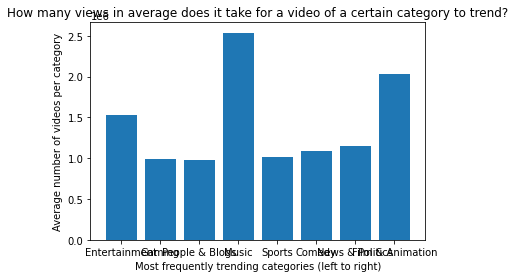

In [ ]:
# plot data
_, ax = plt.subplots()
ax.bar(dataset['categories'], dataset['average_view_count'])
ax.set_xlabel('Most frequently trending categories (left to right)')
ax.set_ylabel('Average number of videos per category')
ax.set_title(
    'How many views in average does it take for a video of a certain category to trend?')
# show plot
plt.show()

Check outliers of this dataset

In [ ]:
df_yout.describe()

,Unnamed: 0,categoryId,view_count,likes,comment_count,age,likes_log,views_log,comment_log,publishing_hour
count,5121.000000,5121.000000,5.121000e+03,5.121000e+03,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000
mean,3216.535052,19.837922,1.368740e+06,5.417753e+04,3715.933216,107.454599,9.648709,13.400379,6.939508,11.514548
std,1999.053777,6.253303,3.994886e+06,1.970892e+05,18471.269456,68.889151,1.886362,1.082574,1.616329,5.826615
min,0.000000,1.000000,1.347800e+04,0.000000e+00,0.000000,14.000000,0.000000,9.508888,0.000000,0.000000
25%,1505.000000,17.000000,3.149060e+05,7.391000e+03,456.000000,54.000000,8.908154,12.660033,6.124683,8.000000
50%,3053.000000,22.000000,6.023040e+05,1.627700e+04,1092.000000,91.000000,9.697570,13.308519,6.996681,11.000000
75%,4705.000000,24.000000,1.287275e+06,4.067300e+04,2576.000000,143.000000,10.613344,14.068039,7.854381,16.000000
max,7899.000000,29.000000,1.669460e+08,8.472237e+06,854011.000000,775.000000,15.952305,18.933181,13.657701,23.000000


In [ ]:
cols = []
for i in df_yout.columns:
    if(is_numeric_dtype(df_yout[i])):
        cols.append(i)
cols

['Unnamed: 0',
 'categoryId',
 'view_count',
 'likes',
 'comment_count',
 'comments_disabled',
 'age',
 'rating_disabled',
 'likes_log',
 'views_log',
 'comment_log',
 'publishing_hour']

In [ ]:
cols = ['categoryId', 'age', 'likes_log', 'views_log', 'comment_log', 'publishing_hour']

In [ ]:
def find_outliers(cols):
    plt.figure(figsize = (18,10))

    plt.subplot(231)
    g1 = sns.boxplot(data=df_yout[cols[0]], width=0.25, palette="Set1")
    g1.set_title("categoryId DISTRIBUTION", fontsize=12)

    plt.subplot(232)
    g1 = sns.boxplot(data=df_yout[cols[1]], width=0.25, palette="Set1_r")
    g1.set_title("age DISTRIBUTION", fontsize=12)

    plt.subplot(233)
    g1 = sns.boxplot(data=df_yout[cols[2]], width=0.25, palette="Set2")
    g1.set_title("likes LOG DISTRIBUTION", fontsize=12)

    plt.subplot(234)
    g1 = sns.boxplot(data=df_yout[cols[3]], width=0.25, palette="Set2_r")
    g1.set_title("VIEWS LOG DISTRIBUTION", fontsize=12)

    plt.subplot(235)
    g1 = sns.boxplot(data=df_yout[cols[4]], width=0.25, palette="Set3")
    g1.set_title("comment LOG DISTRIBUTION", fontsize=12)

    plt.subplot(236)
    g1 = sns.boxplot(data=df_yout[cols[5]], width=0.25, palette="Set3_r")
    g1.set_title("publishing_hour DISTRIBUTION", fontsize=12)

    plt.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.5, hspace = 0.6)

    plt.show()

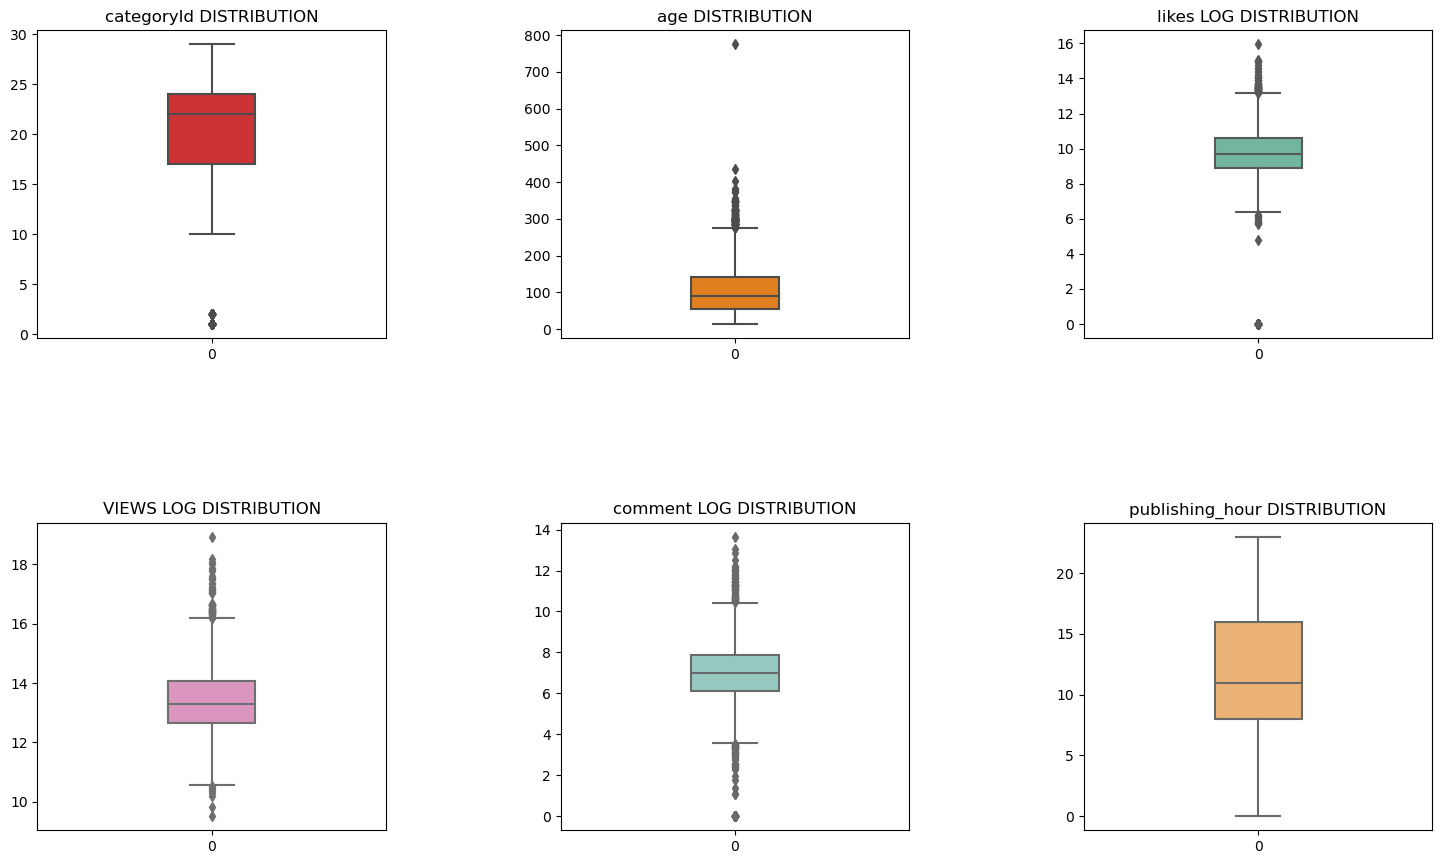

In [ ]:
find_outliers(cols=cols)

In [ ]:
def drop_outliers(df, field_names):
    print("before dropping outliers: {}".format(df_yout.shape[0]))
    for field_name in field_names:
        iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
        df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
        df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)
    print("after dropping outliers: {}".format(df_yout.shape[0]))

In [ ]:
def median_impute_outliers(df, field_names):
    print("before dropping outliers: {}".format(df_yout.shape[0]))
    for field_name in field_names:
        q1 = df_yout[field_name].quantile(0.25)
        q3 = df_yout[field_name].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
        med = np.median(df_yout[field_name])
        for i in df_yout[field_name]:
            if i > Upper_tail or i < Lower_tail:
                    df_yout[field_name] = df_yout[field_name].replace(i, med)
    print("after dropping outliers: {}".format(df_yout.shape[0]))

def zero_impute_outliers(df, field_names):
    print("before dropping outliers: {}".format(df_yout.shape[0]))
    for field_name in field_names:
        q1 = df_yout[field_name].quantile(0.25)
        q3 = df_yout[field_name].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
        for i in df_yout[field_name]:
            if i > Upper_tail or i < Lower_tail:
                    df_yout[field_name] = df_yout[field_name].replace(i, 0)
    print("after dropping outliers: {}".format(df_yout.shape[0]))

In [ ]:
median_impute_outliers(df_yout, cols)
drop_outliers(df_yout, cols)

before dropping outliers: 5121
after dropping outliers: 5121
before dropping outliers: 5121
after dropping outliers: 5030


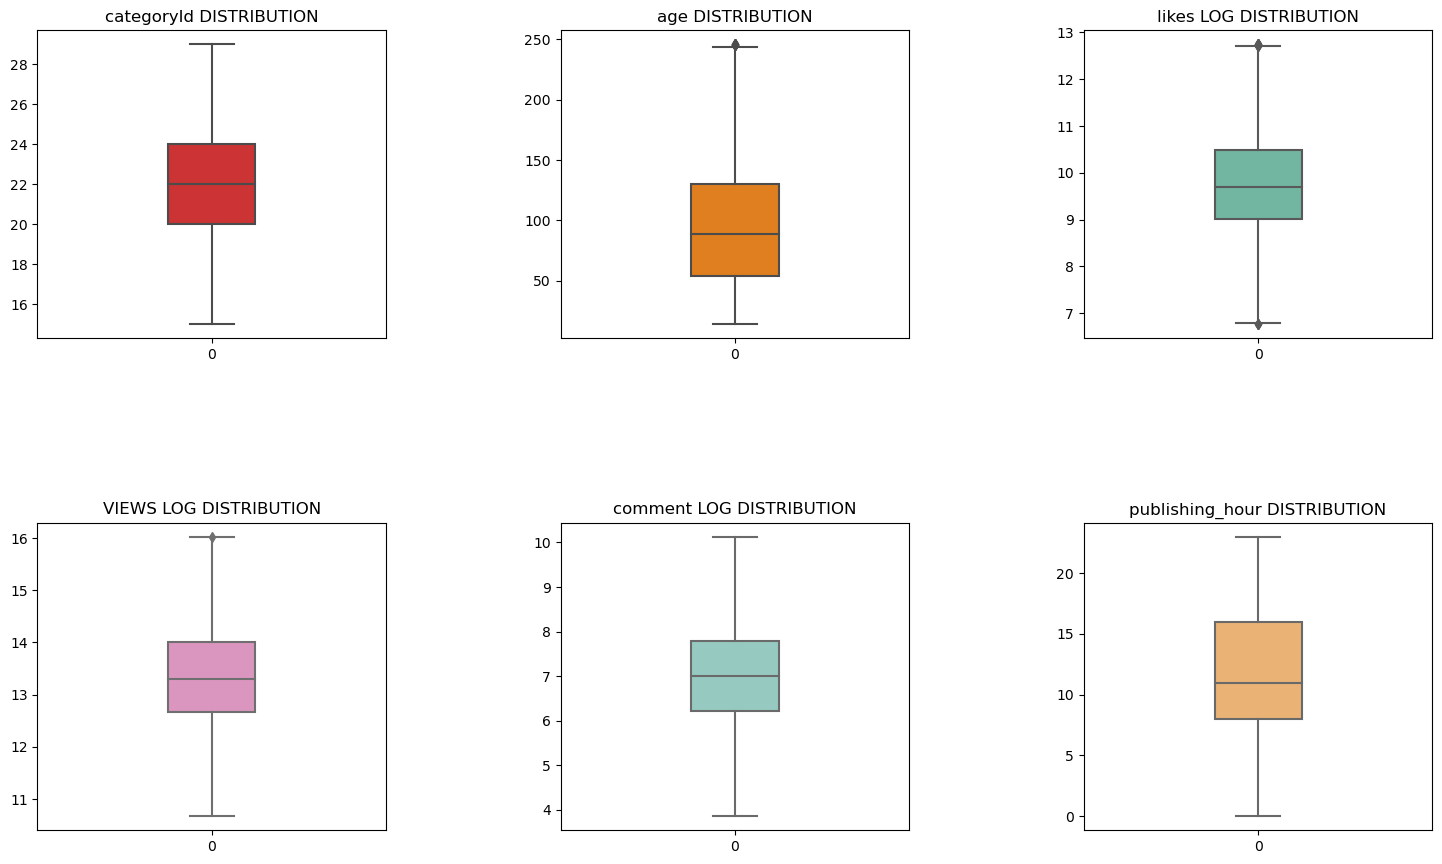

In [ ]:
find_outliers(cols=cols)

## Predictive analysis of number of views for YouTube’s trending videos

In [ ]:
df_yout.columns

Index(['Unnamed: 0', 'video_id', 'title', 'publishedAt', 'channelId',
       'channelTitle', 'categoryId', 'trending_date', 'view_count', 'likes',
       'comment_count', 'comments_disabled', 'description', 'age',
       'rating_disabled', 'likes_log', 'views_log', 'comment_log',
       'publishing_hour', 'category_name'],
      dtype='object')

In [ ]:
x_col = ['comment_count', 'likes', 'rating_disabled', 'age', 'publishing_hour']
y_col = ['view_count']

Metrics for evaluating regression model

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
import numpy as np

def run_experiment(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Evaluation of model {}:".format(model))
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    print("\n")

Normalizing data

In [ ]:
# train-test 70-30 split
df_train, df_test = train_test_split(df_yout, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)

In [ ]:
def linear_regression_scaller():
    # rescale the features for Linear Regression
    scaler = MinMaxScaler()

    # apply scaler() to all the numeric columns 
    numeric_vars = ['age', 'comment_count', 'likes', 'view_count']
    df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
    df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])

In [ ]:
def sgd_regression_scaller():
    # rescale the features for Linear Regression
    scaler = StandardScaler()

    # apply scaler() to all the numeric columns 
    numeric_vars = ['age', 'comment_count', 'likes', 'view_count']
    df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
    df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])

Train-Test-Split

In [ ]:
# TODO

# split into X and y for both train and test sets
# reshaping is required since sklearn requires the data to be in shape
# (n, 1), not as a series of shape (n, )
X_train = np.array(df_train[x_col]).reshape(-1, len(x_col))
y_train = np.array(df_train[y_col]).reshape(-1, 1)

X_test = np.array(df_test[x_col]).reshape(-1, len(x_col))
y_test = np.array(df_test[y_col]).reshape(-1, 1)

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((3521, 5), (3521, 1)), ((1509, 5), (1509, 1)))

In [ ]:
# TODO

In [ ]:
run_experiment(LinearRegression(), X_train, y_train, X_test, y_test)
run_experiment(SGDRegressor(), X_train, y_train, X_test, y_test)

Evaluation of model LinearRegression():
R^2 :  0.5986911937993962
MAE : 0.010660216521453904
RMSE: 0.03266040244717794


Evaluation of model SGDRegressor():
R^2 :  -0.008880341248229229
MAE : 0.01385971625234205
RMSE: 0.05178476583344438




In [ ]:
"""
Evaluation of model LinearRegression():
R^2 :  0.47737213938947287
MAE : 0.056716913689464805
RMSE: 0.0928679362743774

Evaluation of model SGDRegressor():
R^2 :  0.30762007884655795
MAE : 0.06851020978979604
RMSE: 0.1068911497125552
"""


'\nEvaluation of model LinearRegression():\nR^2 :  0.47737213938947287\nMAE : 0.056716913689464805\nRMSE: 0.0928679362743774\n\nEvaluation of model SGDRegressor():\nR^2 :  0.30762007884655795\nMAE : 0.06851020978979604\nRMSE: 0.1068911497125552\n'